# Проект 3. Статистический анализ данных

## Анализ поведения клиентов оператора сотовой связи
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Начнем с импорта всех датасетов:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import math
from math import factorial
pd.set_option('display.max_columns', None)

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')

Просмотрим первично наши данные:

In [3]:
calls.head(2)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


In [4]:
users.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


In [5]:
tariffs.head(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
messages.head(2)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000


In [7]:
internet.head(2)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


Проверим какие типы данных присутствуют в наших таблицах и поменяем их на более удобные и подходящие:

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].apply(math.ceil)

In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


столбец с датами звонков переведен во временной тип, а продолжительность звонков округлена вверх согласно правилам тарификации оператора связи.

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Столбцы с датами хранились в виде текста, была произведена замена на временной тип данных.

In [14]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


tariffs все типы данных в норме

In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [17]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Даты сообщений также переведены во временной тип

In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [21]:
calls = calls.merge(users, on = 'user_id', how = 'left')
calls['month'] = calls['call_date'].dt.month_name()
calls.head(2)

,id,call_date,duration,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000_0,2018-07-25,0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July
1,1000_1,2018-08-17,0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August


Теперь произведем группировку и объединение таблиц для удобного анализа:

In [22]:
calls_pivot = calls.pivot_table(index = ['user_id', 'city', 'tariff', 'month'], values = 'duration', aggfunc=['count', 'sum'])
calls_pivot.head(10)

count      sum
                                   duration duration
user_id city      tariff month                      
1000    Краснодар ultra  August          52      408
                         December        46      333
                         July            47      340
                         June            43      172
                         May             22      159
                         November        43      338
                         October         57      350
                         September       58      466
1001    Москва    smart  December        63      414
                         November        59      430

Подсчитаны количество звонков и продолжительность в минутах по месяцам для отдельных абонентов.

In [23]:
messages = messages.merge(users, on = 'user_id', how = 'left')
messages['month'] = messages['message_date'].dt.month_name()
messages.head()

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000_0,2018-06-27,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June
1,1000_1,2018-10-08,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,October
2,1000_2,2018-08-04,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August
3,1000_3,2018-06-16,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June
4,1000_4,2018-12-05,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December


In [24]:
messages_pivot = messages.pivot_table(index = ['user_id', 'city', 'tariff', 'month'], values = 'id', aggfunc = 'count')
messages_pivot .head(10)

id
user_id city        tariff month        
1000    Краснодар   ultra  August     81
                           December   70
                           July       75
                           June       60
                           May        22
                           November   58
                           October    73
                           September  57
1002    Стерлитамак smart  August     13
                           December   12

Сгруппировано и подсчитано количество сообщений по месяцам для абонентов

In [25]:
calls_messages_merged = calls_pivot.merge(messages_pivot, on = ['user_id', 'city', 'tariff', 'month'], how = 'left')
#calls_messages_merged['id'] = calls_messages_merged['id'].astype('int64')
calls_messages_merged

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(count, duration)  (sum, duration)    id
user_id city        tariff month                                              
1000    Краснодар   ultra  August                    52              408  81.0
                           December                  46              333  70.0
                           July                      47              340  75.0
                           June                      43              172  60.0
                           May                       22              159  22.0
...                                                 ...              ...   ...
1498    Владикавказ smart  September                 59              471  44.0
1499    Пермь       smart  December                  69              492  66.0
                           November                  74              612  59.0
                           October                   68              449  48.0
                           September                  9               70  11.0

[3174 rows x 3 columns]

In [26]:
internet = internet.merge(users, on = 'user_id', how = 'left')
internet['month'] = internet['session_date'].dt.month_name()
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,0,1000_0,112.95,2018-11-25,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,November
1,1,1000_1,1052.81,2018-09-07,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,September
2,2,1000_2,1197.26,2018-06-25,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June
3,3,1000_3,550.27,2018-08-22,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August
4,4,1000_4,302.56,2018-09-24,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,September


In [27]:
internet_pivot = internet.pivot_table(index = ['user_id', 'city', 'tariff', 'month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot.head(10)

mb_used
user_id city      tariff month              
1000    Краснодар ultra  August     14055.93
                         December    9817.61
                         July       14003.64
                         June       23233.77
                         May         2253.49
                         November   14756.47
                         October    14702.49
                         September  14568.91
1001    Москва    smart  December   14036.66
                         November   18429.34

Подсчитано использование мегабайт пользователями по месяцам

In [28]:
cmi_merged = calls_messages_merged.merge(internet_pivot, on = ['user_id', 'city', 'tariff', 'month'], how = 'left')
cmi_merged.columns = ['calls_count', 'calls_sum', 'messages_count', 'internet_mb_sum']
cmi_merged = cmi_merged.reset_index()
cmi_merged.head(10)

,user_id,city,tariff,month,calls_count,calls_sum,messages_count,internet_mb_sum
0,1000,Краснодар,ultra,August,52,408,81.0,14055.93
1,1000,Краснодар,ultra,December,46,333,70.0,9817.61
2,1000,Краснодар,ultra,July,47,340,75.0,14003.64
3,1000,Краснодар,ultra,June,43,172,60.0,23233.77
4,1000,Краснодар,ultra,May,22,159,22.0,2253.49
5,1000,Краснодар,ultra,November,43,338,58.0,14756.47
6,1000,Краснодар,ultra,October,57,350,73.0,14702.49
7,1000,Краснодар,ultra,September,58,466,57.0,14568.91
8,1001,Москва,smart,December,63,414,NaN,14036.66
9,1001,Москва,smart,November,59,430,NaN,18429.34


Получена итоговая таблица, в которой имеются данные по пользователям, городу, тарифу, месяцу, количеству звонков и их продолжительности, количеству СМС, Использованному трафику интернета.

In [29]:
f"Количество уникальных пользователей: {cmi_merged.user_id.nunique()}"

'Количество уникальных пользователей: 492'

Ниже создаю функции для подсчета превышения по тарифу (excess) и выручки от использования основного пакета и дополнительных минут, смс, гигабайтов

In [30]:
def excess_calls(row):
    calls = row['calls_sum']
    tariff = row['tariff']
    if tariff == 'smart':
        ex_calls = calls - 500
        if ex_calls > 0:
            return ex_calls * 3
        else:
            ex_calls = 0
            return ex_calls
    else:
        if tariff == 'ultra':
            ex_calls = calls - 3000
            if ex_calls > 0:
                return ex_calls * 3
            else:
                ex_calls = 0
                return ex_calls
            
def excess_messages(row):
    messages = row['messages_count']
    tariff = row['tariff']
    if tariff == 'smart':
        ex_messages = messages - 50
        if ex_messages > 0:
            return ex_messages * 1
        else:
            ex_messages = 0
            return ex_messages
    else:
        if tariff == 'ultra':
            ex_messages = messages - 1000
            if ex_messages > 0:
                return ex_messages * 1
            else:
                ex_messages = 0
                return ex_messages   

def excess_internet(row):
    internet = row['internet_mb_sum']
    tariff = row['tariff']
    if tariff == 'smart':
        ex_internet = (internet - 15360) / 1024 * 200
        if ex_internet > 0:
            return ex_internet
        else:
            ex_internet = 0
            return ex_internet
    else:
        if tariff == 'ultra':
            ex_internet = (internet - 30720) / 1024 * 150
            if ex_internet > 0:
                return ex_internet
            else:
                ex_internet = 0
                return ex_internet 

def proceed(row):
    calls = row['excess_calls']
    messages = row['excess_messages']
    internet = row['excess_internet']
    tariff = row['tariff']
    if tariff == 'smart':
        proceed_all = calls + messages + internet + 550
        return proceed_all
    else:
        if tariff == 'ultra':
            proceed_all = calls + messages + internet + 1950
            return proceed_all
            
cmi_merged['excess_calls'] = np.round(cmi_merged.apply(excess_calls, axis=1))
cmi_merged['excess_messages'] = np.round(cmi_merged.apply(excess_messages, axis=1))
cmi_merged['excess_internet'] = np.round(cmi_merged.apply(excess_internet, axis=1))
cmi_merged['proceed_all'] = np.round(cmi_merged.apply(proceed, axis=1))
cmi_merged.tail(30)

,user_id,city,tariff,month,calls_count,calls_sum,messages_count,internet_mb_sum,excess_calls,excess_messages,excess_internet,proceed_all
3144,1494,Омск,smart,October,52,354,NaN,17767.24,0,0.0,470.0,1020.0
3145,1494,Омск,smart,September,66,501,NaN,16962.51,3,0.0,313.0,866.0
3146,1495,Иркутск,ultra,August,17,92,13.0,2614.07,0,0.0,0.0,1950.0
3147,1495,Иркутск,ultra,December,155,1031,84.0,23426.76,0,0.0,0.0,1950.0
3148,1495,Иркутск,ultra,November,129,954,79.0,38939.11,0,0.0,1204.0,3154.0
3149,1495,Иркутск,ultra,October,152,1030,82.0,29363.00,0,0.0,0.0,1950.0
3150,1495,Иркутск,ultra,September,112,813,82.0,33067.62,0,0.0,344.0,2294.0
3151,1496,Вологда,smart,April,67,521,49.0,21074.67,63,0.0,1116.0,1729.0
3152,1496,Вологда,smart,August,88,527,41.0,23530.03,81,0.0,1596.0,2227.0
3153,1496,Вологда,smart,December,80,518,51.0,20736.15,54,1.0,1050.0,1655.0


Теперь строю гистограммы для оценки распределений показателей обоих тарифов смарт и ультра попарно

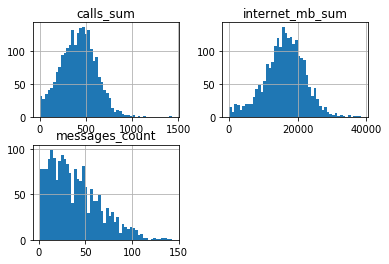

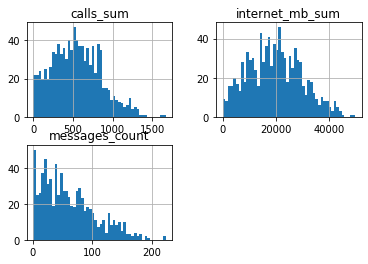

In [31]:
for column in [['calls_sum', 'messages_count', 'internet_mb_sum']]:
    cmi_merged[cmi_merged['tariff'] == 'smart'].hist(column, bins=50)
    cmi_merged[cmi_merged['tariff'] == 'ultra'].hist(column, bins=50)
    plt.show()
  
#cmi_merged[cmi_merged['tariff'] == 'smart'].hist('calls_sum', bins = 50) 
#cmi_merged[cmi_merged['tariff'] == 'ultra'].hist('calls_sum', bins = 50) 
#cmi_merged[cmi_merged['tariff'] == 'smart'].hist('messages_count', bins = 50)
#cmi_merged[cmi_merged['tariff'] == 'ultra'].hist('messages_count', bins = 50)
#cmi_merged[cmi_merged['tariff'] == 'smart'].hist('internet_mb_sum', bins = 50)
#cmi_merged[cmi_merged['tariff'] == 'ultra'].hist('internet_mb_sum', bins = 50)

распределения всех трех величин можно описать скошенностью вправо, при этом распределение использованного трафика интернета наиболее похоже на нормальное. В целом пользователи тарифа Ультра используют больше звонков минут и интернета, чем пользователи Смарта. Это и логично, люди не просто так платят бОльшую абонентскую плату за пакеты с бОльшим содержанием
Также стоит отметить, что пользователи Смарта чаще выходят за пределы своих пакетов, однако даже с такой особенностью приносят меньше выручки относительно пользователей Ультра

In [32]:
print(cmi_merged[cmi_merged['tariff'] == 'smart']['calls_sum'].mean())
print(cmi_merged[cmi_merged['tariff'] == 'ultra']['calls_sum'].mean())
print(cmi_merged[cmi_merged['tariff'] == 'smart']['messages_count'].mean())
print(cmi_merged[cmi_merged['tariff'] == 'ultra']['messages_count'].mean())
print(cmi_merged[cmi_merged['tariff'] == 'smart']['internet_mb_sum'].mean())
print(cmi_merged[cmi_merged['tariff'] == 'ultra']['internet_mb_sum'].mean())

419.0629779577148
545.4511041009464
38.74739039665971
61.19553805774278
16216.66127362736
19669.283602550477


In [33]:
print(np.var(cmi_merged[cmi_merged['tariff'] == 'smart']['calls_sum']))
print(np.var(cmi_merged[cmi_merged['tariff'] == 'ultra']['calls_sum']))
print(np.var(cmi_merged[cmi_merged['tariff'] == 'smart']['messages_count']))
print(np.var(cmi_merged[cmi_merged['tariff'] == 'ultra']['messages_count']))
print(np.var(cmi_merged[cmi_merged['tariff'] == 'smart']['internet_mb_sum']))
print(np.var(cmi_merged[cmi_merged['tariff'] == 'ultra']['internet_mb_sum']))
print()
print(np.std(cmi_merged[cmi_merged['tariff'] == 'smart']['calls_sum']))
print(np.std(cmi_merged[cmi_merged['tariff'] == 'ultra']['calls_sum']))
print(np.std(cmi_merged[cmi_merged['tariff'] == 'smart']['messages_count']))
print(np.std(cmi_merged[cmi_merged['tariff'] == 'ultra']['messages_count']))
print(np.std(cmi_merged[cmi_merged['tariff'] == 'smart']['internet_mb_sum']))
print(np.std(cmi_merged[cmi_merged['tariff'] == 'ultra']['internet_mb_sum']))

35828.06530953033
94104.36117385984
718.7973574905967
1996.9499538443522
34412098.457164586
99465187.55618353

189.2830296395594
306.76434143143143
26.810396444114673
44.68724598634774
5866.18261369049
9973.223528838784


рассчитаны показатели дисперсии и стандартного отклонения

Мне показалось логичным, что для проверки гипотез о том что средняя выручка пользователей Ультра и Смарта различается, нулевой гипотезой будет то, что Средняя выручка пользователей тарифов равна. Альтернативная гипотеза - что выручка отличается (не равна), причем неважно у кого больше у кого меньше. для проверки использовал т-тест, потому что имеется предположение, что данные распределены нормально на всей генеральной совокупности.

In [34]:
sample_1 = cmi_merged[cmi_merged['tariff'] == 'smart']['proceed_all']
sample_2 = cmi_merged[cmi_merged['tariff'] == 'ultra']['proceed_all']
alpha = .05
results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.5306521554007666e-192
Отвергаем нулевую гипотезу


Получается, что средние этих двух совокупностей не равны, а отличаются, но как именно сказать мы не можем

Для проверки гипотезы про среднюю выручку в москве и других регионах принята нулевая гипотеза, что выручка в москве равна выручке пользователей в других регионах, а альтернативная, что выручки не равны

In [35]:
moscow = cmi_merged[cmi_merged['city'] == 'Москва']
other_cities = cmi_merged[cmi_merged['city'] != 'Москва']

sample_3 = moscow[moscow['tariff'] == 'smart']['proceed_all']
sample_4 = other_cities[other_cities['tariff'] == 'ultra']['proceed_all']
alpha = .05
results2 = st.ttest_ind(
    sample_3, 
    sample_4)

print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.228204721313995e-126
Отвергаем нулевую гипотезу


Так как мы получили результат с отвержением нулевой гипотезы, можно сделать вывод что средние выручка в москве и суммарно в других гордах отличается друг от друга, что логично - других городов много, причем среди них есть как небольшие города, так и города-миллионеры

### общие выводы

Была проделана работа по статистическому анализу данных на данных о пользователях тарифов Смарт и Ультра.

1. Данные были приведены к нужным типам, наиболее частое - приведение даты к временному типу
2. Звонки длительностью в 0 минут оставлены в датасете, так как не влияют и не искажают данные
3. посчитаны для пользователей количество и время звонков, количество сообщений, интернет трафик по месяцам, эти значения приведены в таблице cmi_merged
4. оценены превышения сверх тарифного пакета, затем на основании этого получены данные о выручке с каждого пользователя по месяцам с использованием созданных функций (для превышения минут, превышения смс, превышения трафика и подсчета дохода с пользователя), 
5. После было описано поведение клиентов и сделан главный вывод о поведении - **пользователи Смарта чаще вылезают за границы пакетов, а пользователи ультры приносят удельно больше выручки, хоть и не часто вылезают за границы**
6. Проверена гипотеза о равенстве средней выручки Смарта и Ультры **t-тест показал , что  выручки не равны (предполагаю, что от Ультры доход больше, хоть и таких пользователей меньше)** 
7. проверена гипотеза о равенстве выручки в москве и в регионах. Гипотеза также была отвергнута, то есть выручки различны. Пороговое значение принято равным 5%, поскольку нет смысла брать значение меньше
8. Исходя из поведения клиентов, стоит отметить, что нельзя выделить то, какой тариф лучше. На основании исследования видно, что пользователи с тарифом Смарт чаще превышают границы, однако их абонентская плата даже с учетом превышения сильно ниже тарифа Ультра. Смарт подходит большинству людей, однако те, кому нужно больше звонков и кому хочется меньше думать о превышениях по пакетам стоит обратить внимание на Ультра. Однако я бы рекомендовал оператору Мегалайн **создать "промежуточный" тариф, который будет иметь порядка 1000-1500 минут, 100-200 смс и 20-25 гб интернет трафика. Думаю что таким образом получится часть людей периодически превышающих лимиты по Смарту перевести на немного более дорогой, но стабильно более дорогой тариф. При этом те, кому слишком много пакетов в Ультре тоже смогут найти для себя более гибкий и подходящий вариант**